# EE 559 Project
Ronald Huang & Henry Chen

### Import Libraries

In [ ]:
# Import packages
import math
import numpy as np
import pandas as pd
import seaborn as sns


# For Computing Priors
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import normalize



# For Model Selection
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold






import matplotlib.pyplot as plt


# For plotting ROC and Precision Recall curves
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay


# For OS agnostic path handling
from os import path


### Data Import

In [ ]:
#Read in data
data_path = 'data/FLIR_groups1and2_train.csv'

read_data = pd.read_csv(data_path, skiprows = 2)
training_data_set = read_data.iloc[:, 2:]

#Seperate by Rounds
round_1 = training_data_set.iloc[:, :27]
round_2 = training_data_set.iloc[:, 28:55]
round_3 = training_data_set.iloc[:, 56:83]
round_4 = training_data_set.iloc[:, 84:111]

In [ ]:
#seperate extra features
# extra_features = training_data_set[['Gender', 'Age', 'Ethnicity', 'T_atm', 'Humidity', 'Distance']]
catagorical_features = training_data_set[['Gender', 'Age', 'Ethnicity',]]

extra_features = training_data_set[['T_atm', 'Humidity', 'Distance']]

target = training_data_set['aveOralM']



In [ ]:
# One-Hot-Encoding
catagorical_features_copy = catagorical_features.copy()

# extra_features = pd.get_dummies(extra_features, columns=['Gender', 'Age', 'Ethnicity'])
catagorical_features_ohe = pd.get_dummies(catagorical_features_copy, columns=['Gender', 'Age', 'Ethnicity'], dtype=int)

catagorical_features_ohe
# catagorical_features_copy = catagorical_features_ohe
# catagorical_features_copy

# extra_3 = extra_features_copy[:,]

,Gender_Female,Gender_Male,Age_18-20,Age_21-25,Age_21-30,Age_26-30,Age_31-40,Age_41-50,Age_51-60,Age_>60,Ethnicity_American Indian or Alaskan Native,Ethnicity_Asian,Ethnicity_Black or African-American,Ethnicity_Hispanic/Latino,Ethnicity_Multiracial,Ethnicity_White
0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
2,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
706,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
707,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0
708,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Clean 'Distance' column and replace non-numeric characters with NaN
extra_features['Distance'] = pd.to_numeric(extra_features['Distance'], errors='coerce')

# Calculate the mean of the 'Distance' column
mean_distance = extra_features['Distance'].mean()

# Replace values greater than 1 with the mean
extra_features.loc[extra_features['Distance'] > 1, 'Distance'] = mean_distance



# # Clean 'Distance' column and replace non-numeric characters with NaN
# extra_features_copy['Distance'] = pd.to_numeric(extra_features_copy['Distance'], errors='coerce')

# # Calculate the mean of the 'Distance' column
# mean_distance = extra_features_copy['Distance'].mean()

# # Replace values greater than 1 with the mean
# extra_features_copy.loc[extra_features_copy['Distance'] > 1, 'Distance'] = mean_distance

/tmp/ipykernel_66/1384857547.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extra_features['Distance'] = pd.to_numeric(extra_features['Distance'], errors='coerce')


In [ ]:
#standardize the extra features

extra_features_stand = (extra_features - extra_features.mean()) / extra_features.std()
extra_features_stand

,T_atm,Humidity,Distance
0,0.062470,-0.135970,1.858188
1,0.062470,-0.282998,1.858188
2,0.062470,-0.282998,1.858188
3,0.062470,-0.209484,1.858188
4,0.062470,-0.209484,1.858188
...,...,...,...
705,0.356691,-1.201922,-0.867774
706,0.356691,-1.113706,-0.458880
707,-1.408633,0.011058,-0.867774
708,-1.408633,0.011058,-0.867774


In [ ]:
# # Label Encoding - We tried label encoding but results were not as good as one-hot


# extra_features_copy = extra_features.copy()

# label_encoder = LabelEncoder()

# extra_features_copy['Gender_encoded'] = label_encoder.fit_transform(extra_features_copy['Gender'])
# extra_features_copy['Age_encoded'] = label_encoder.fit_transform(extra_features_copy['Age'])
# extra_features_copy['Ethnicity_encoded'] = label_encoder.fit_transform(extra_features_copy['Ethnicity'])

# extra_features_copy = extra_features_copy.drop(['Gender','Age','Ethnicity'], axis=1)

# # Display the encoded DataFrame
# extra_features_copy

In [ ]:
#Function to find empty rows 
def find_empty(round):
    empty_rows = []
    
    for i, row in round.iterrows():
        if row.isnull().all() or row.isna().any().any():
            empty_rows.append(i)
            
    return empty_rows
    
#find empty rows in each round
round_1_empty_rows = find_empty(round_1)
round_2_empty_rows = find_empty(round_2)
round_3_empty_rows = find_empty(round_3)
round_4_empty_rows = find_empty(round_4)

#Compute the means of every feature
round_1_means = (round_1.mean()).values  #dtype is float64
round_2_means = (round_2.mean()).values
round_3_means = (round_3.mean()).values
round_4_means = (round_4.mean()).values

In [ ]:
#Function to insert means into missing rows 
def insert_mean(round_num, empty_rows, mean):
    rounds_final = round_num
    
    for i in empty_rows:
        rounds_final.loc[i] = mean

    return rounds_final  
    
#insert mean array into each empty row
final_round_1 = insert_mean(round_1, round_1_empty_rows, round_1_means)
final_round_2 = insert_mean(round_2, round_2_empty_rows, round_2_means)
final_round_3 = insert_mean(round_3, round_3_empty_rows, round_3_means)
final_round_4 = insert_mean(round_4, round_4_empty_rows, round_4_means)

#check if there are any empty rows after inserting
test_empty_1 = find_empty(final_round_1)
print(test_empty_1)
test_empty_2 = find_empty(final_round_2)
print(test_empty_2)
test_empty_3 = find_empty(final_round_3)
print(test_empty_3)
test_empty_4 = find_empty(final_round_4)
print(test_empty_4)

# test_empty_extra = find_empty(extra_features)
# print(test_empty_extra)

[]
[]
[]
[]


In [ ]:
# Build and standardise dataset with means from the 4 rounds (NO encoded features yet)
final_dataset_means = pd.DataFrame()

for i in range(final_round_1.iloc[0, :].size):
    avg_values = (final_round_1.iloc[:, i] + final_round_2.iloc[:, i] + final_round_3.iloc[:, i] + final_round_4.iloc[:, i]) / 4
    
    final_dataset_means = pd.concat([final_dataset_means, avg_values], axis = 1)

# Standardise data set
final_dataset_means_stand = (final_dataset_means - final_dataset_means.mean()) / final_dataset_means.std()

col_names = ['T_offset_1','Max1R13_1','Max1L13_1','aveAllR13_1','aveAllL13_1','T_RC_1','T_RC_Dry_1','T_RC_Wet_1','T_RC_Max_1','T_LC_1','T_LC_Dry_1','T_LC_Wet_1','T_LC_Max_1','RCC_1','LCC_1','canthiMax_1','canthi4Max_1','T_FHCC_1','T_FHRC_1','T_FHLC_1','T_FHBC_1','T_FHTC_1','T_FH_Max_1','T_FHC_Max_1','T_Max_1','T_OR_1','T_OR_Max_1']

final_dataset_means_stand.columns = col_names
print(final_dataset_means_stand.shape)

features_plus_extra = pd.concat([final_dataset_means_stand, extra_features_stand], axis = 1)

print(features_plus_extra.shape)
features_plus_extra

#final_dataset_means_stand has standardized features without encoded features or labels

#features_plus_extra has standardized features AND standardized extra features without encoded features or labels

(710, 27)
(710, 30)


,T_offset_1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC_1,T_RC_Dry_1,T_RC_Wet_1,T_RC_Max_1,T_LC_1,...,T_FHBC_1,T_FHTC_1,T_FH_Max_1,T_FHC_Max_1,T_Max_1,T_OR_1,T_OR_Max_1,T_atm,Humidity,Distance
0,-0.721540,-0.990720,-0.371420,-0.685640,-0.095595,-1.230225,-1.064954,-1.395203,-1.196208,-0.508548,...,-1.455076,-2.134077,-1.662317,-1.815942,-0.791048,-0.286742,-0.316433,0.062470,-0.135970,1.858188
1,-0.491898,-1.885449,-2.037936,-1.380633,-1.224645,-1.764973,-1.727292,-1.628103,-1.760348,-2.045221,...,-0.714249,-0.731523,-1.360446,-0.660159,-1.908290,-1.321512,-1.355600,0.062470,-0.282998,1.858188
2,-0.247441,0.169632,-0.099335,-0.866782,-0.287167,0.130950,0.217444,0.225591,0.136329,-0.182437,...,0.604501,0.204682,-0.049040,0.336205,-0.316086,0.142426,0.126881,0.062470,-0.282998,1.858188
3,-0.047431,-0.631896,0.085293,-0.707821,0.442436,-0.797566,-0.660975,-0.720268,-0.821736,0.000382,...,-0.198385,0.551814,0.460677,0.500052,-0.731678,-1.564707,-1.593942,0.062470,-0.209484,1.858188
4,-0.151140,-0.030750,0.187325,0.068501,0.638084,-0.029474,-0.144258,0.140036,-0.014433,0.089322,...,0.371781,-0.976970,0.094473,0.601903,-0.353867,-0.377344,-0.383169,0.062470,-0.209484,1.858188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,-0.040023,-0.151912,-0.075042,0.053714,0.022609,-0.102394,0.024850,-0.686997,-0.033886,-0.123144,...,0.336873,0.190656,-0.425141,0.150217,-0.164961,-0.048315,-0.016123,0.356691,-1.201922,-0.867774
706,-0.269665,0.174292,-0.070183,0.486236,0.377220,-0.010029,0.090614,-0.021568,0.014747,-0.133026,...,0.856615,0.537789,0.460677,0.274209,0.660826,0.738492,0.717967,0.356691,-1.113706,-0.458880
707,0.071094,2.182772,1.732375,2.009306,1.856805,2.138685,2.185667,2.174347,2.115681,1.660583,...,0.383417,0.611423,1.658263,0.473482,1.886013,1.902012,1.933507,-1.408633,0.011058,-0.867774
708,0.374813,2.578876,2.913027,2.245899,2.455976,2.542176,2.570856,2.516567,2.529060,2.876086,...,1.539262,1.288155,1.633519,1.390138,2.307002,1.797105,1.761901,-1.408633,0.011058,-0.867774


In [ ]:
# Build final dataset with encoded features
raw_dataset_nolabel = pd.concat([features_plus_extra, catagorical_features_ohe], axis=1)

raw_dataset = pd.concat([raw_dataset_nolabel, target], axis=1)

print(raw_dataset.shape)
raw_dataset


#raw_dataset has standardized features + encoded features + labels

(710, 47)


,T_offset_1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC_1,T_RC_Dry_1,T_RC_Wet_1,T_RC_Max_1,T_LC_1,...,Age_41-50,Age_51-60,Age_>60,Ethnicity_American Indian or Alaskan Native,Ethnicity_Asian,Ethnicity_Black or African-American,Ethnicity_Hispanic/Latino,Ethnicity_Multiracial,Ethnicity_White,aveOralM
0,-0.721540,-0.990720,-0.371420,-0.685640,-0.095595,-1.230225,-1.064954,-1.395203,-1.196208,-0.508548,...,1,0,0,0,0,0,0,0,1,36.59
1,-0.491898,-1.885449,-2.037936,-1.380633,-1.224645,-1.764973,-1.727292,-1.628103,-1.760348,-2.045221,...,0,0,0,0,0,1,0,0,0,37.19
2,-0.247441,0.169632,-0.099335,-0.866782,-0.287167,0.130950,0.217444,0.225591,0.136329,-0.182437,...,0,0,0,0,0,0,0,0,1,37.34
3,-0.047431,-0.631896,0.085293,-0.707821,0.442436,-0.797566,-0.660975,-0.720268,-0.821736,0.000382,...,0,0,0,0,0,1,0,0,0,37.09
4,-0.151140,-0.030750,0.187325,0.068501,0.638084,-0.029474,-0.144258,0.140036,-0.014433,0.089322,...,0,0,0,0,0,0,0,0,1,37.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,-0.040023,-0.151912,-0.075042,0.053714,0.022609,-0.102394,0.024850,-0.686997,-0.033886,-0.123144,...,0,0,0,0,0,0,0,0,1,36.89
706,-0.269665,0.174292,-0.070183,0.486236,0.377220,-0.010029,0.090614,-0.021568,0.014747,-0.133026,...,0,0,0,0,1,0,0,0,0,37.14
707,0.071094,2.182772,1.732375,2.009306,1.856805,2.138685,2.185667,2.174347,2.115681,1.660583,...,0,0,0,0,0,0,0,1,0,37.79
708,0.374813,2.578876,2.913027,2.245899,2.455976,2.542176,2.570856,2.516567,2.529060,2.876086,...,0,0,0,0,0,0,0,0,1,38.14


### Exploratory Data Analysis (EDA)

<Axes: >

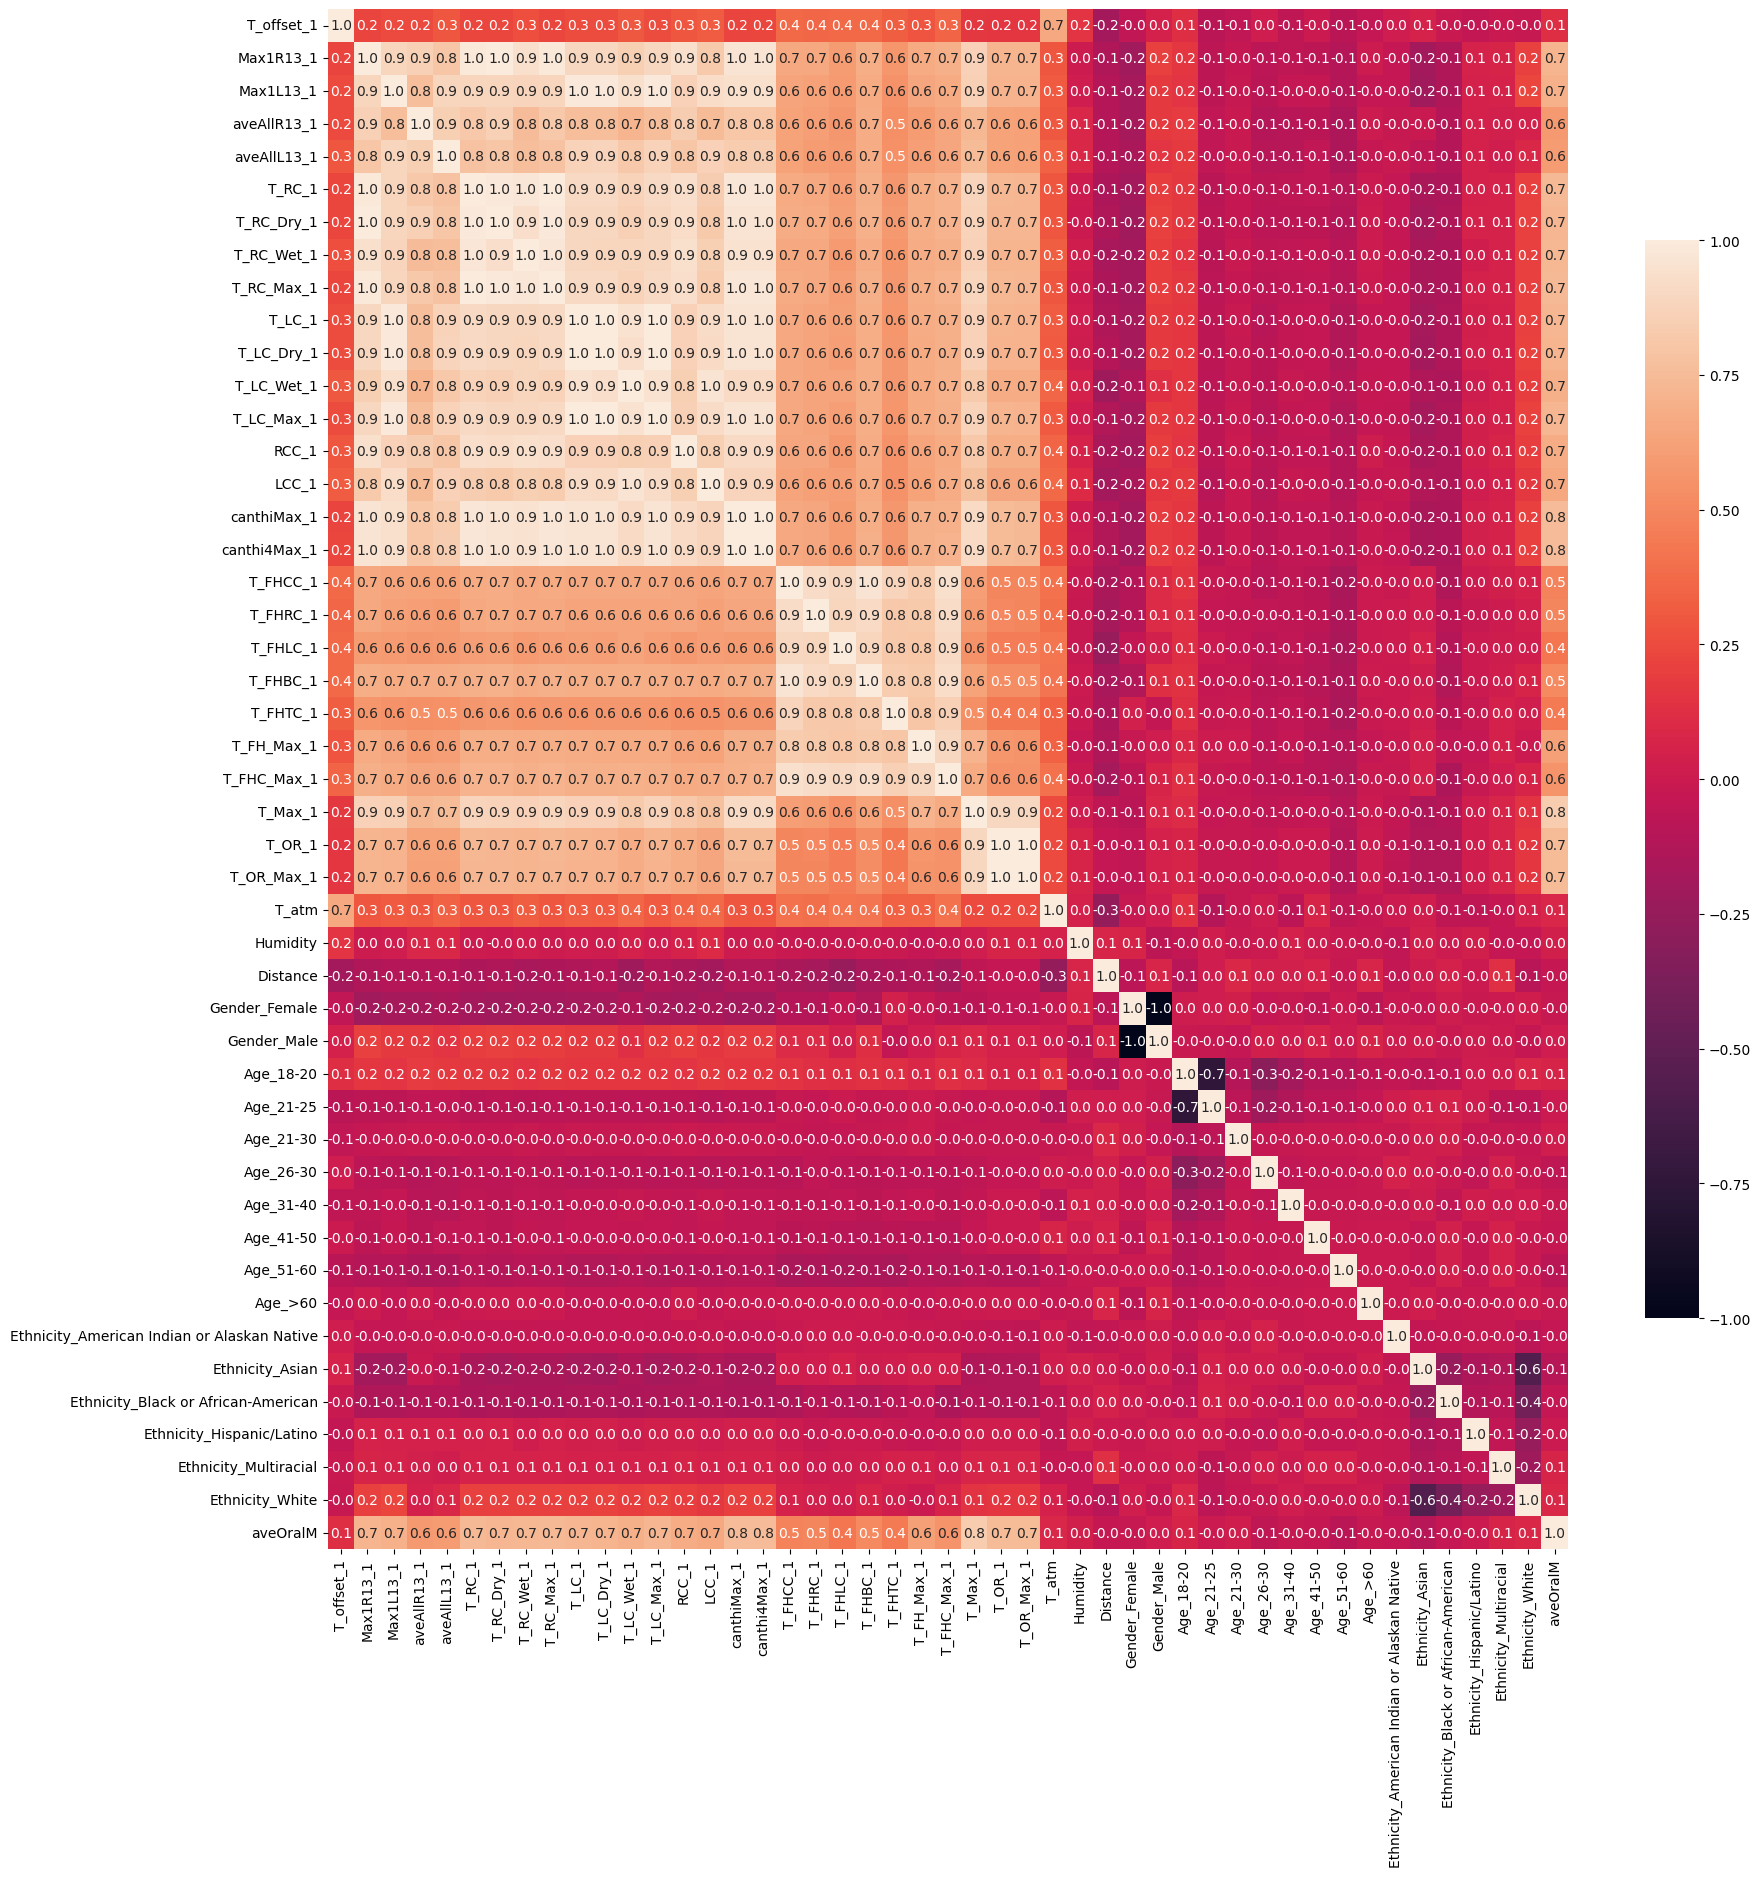

In [ ]:
# Correlation Matrix
plt.figure(figsize=(20, 20))
corrMatrix = raw_dataset.corr()
sns.heatmap(corrMatrix, annot=True, fmt=".1f", cbar_kws={"shrink": 0.7})

In [ ]:
##########OTHER RANDOM PLOTS TO DO WITH THE DATA#############
# stuff like means, stds of the features

### Baseline model on entire raw dataset

In [ ]:
#split data into test and validation sets
X_training_data = raw_dataset.iloc[:, :-1]  # Features
y_training_data = raw_dataset.iloc[:, -1]   # Labels

x_train, x_val, y_train, y_val = train_test_split(X_training_data, y_training_data, test_size=0.2, random_state=42)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


(568, 46)
(142, 46)
(568,)
(142,)


In [ ]:
#Linear Regression function
def LinReg(train_data, train_label, val_data, val_label):
    '''
    Function trains the model based off training data and returns prediction labels
    '''
    model = LinearRegression()
    model.fit(train_data, train_label)
    prediction_label = model.predict(val_data)

    return prediction_label

In [ ]:
#Compute mse, root mse, mae, accuracy given validation label and prediction labels from model
def compute_metrics(val_label, prediction_label):

    mse = mean_squared_error(val_label, prediction_label)
    r_mse = np.sqrt(mse)
    mae = mean_absolute_error(val_label, prediction_label)
        
    return mse, r_mse, mae

In [ ]:
model_test_prediction_raw = LinReg(x_train, y_train, x_val, y_val) # train linear regression model

mse_raw, r_mse_raw, mae_raw = compute_metrics(y_val, model_test_prediction_raw) # calculate metrics

print("Mean Squared Error for all features: ", mse_raw)
print("Root Mean Squared Error for all features: ", r_mse_raw)
print("Mean Absolute Error for all features: ", mae_raw)

Mean Squared Error for all features:  0.06689753989312418
Root Mean Squared Error for all features:  0.25864558742248855
Mean Absolute Error for all features:  0.2085629688302917


## We attempted 2 feature engineering and reduction techniques: We found better results using path: {TO FILL AFTER}

### Path 1: Polynomial Feature Mapping and PCA

In [ ]:
poly_map = PolynomialFeatures(degree=2, include_bias=True)

#perform polynomial feature expansion
#this data is expanded WITHOUT one hot encoded features and labels

data_expanded = poly_map.fit_transform(features_plus_extra)
data_expanded_df = pd.DataFrame(data_expanded)
print(data_expanded_df.shape)

#data_expanded_df has MAPPED FEATURES without one hot encoded features or labels

# add encoded features no labels

# data_expanded_df_nolabel = pd.concat([data_expanded_df, extra_features_copy], axis=1)
# data_expanded_df_nolabel.columns = data_expanded_df_nolabel.columns.astype(str)
# print(data_expanded_df_nolabel.shape)

data_expanded_df

(710, 496)


,0,1,2,3,4,5,6,7,8,9,...,486,487,488,489,490,491,492,493,494,495
0,1.0,-0.721540,-0.990720,-0.371420,-0.685640,-0.095595,-1.230225,-1.064954,-1.395203,-1.196208,...,0.100130,-0.019768,0.043025,-0.587992,0.003903,-0.008494,0.116081,0.018488,-0.252657,3.452862
1,1.0,-0.491898,-1.885449,-2.037936,-1.380633,-1.224645,-1.764973,-1.727292,-1.628103,-1.760348,...,1.837653,-0.084684,0.383632,-2.518960,0.003903,-0.017679,0.116081,0.080088,-0.525863,3.452862
2,1.0,-0.247441,0.169632,-0.099335,-0.866782,-0.287167,0.130950,0.217444,0.225591,0.136329,...,0.016099,0.007926,-0.035907,0.235769,0.003903,-0.017679,0.116081,0.080088,-0.525863,3.452862
3,1.0,-0.047431,-0.631896,0.085293,-0.707821,0.442436,-0.797566,-0.660975,-0.720268,-0.821736,...,2.540650,-0.099574,0.333905,-2.961843,0.003903,-0.013086,0.116081,0.043883,-0.389260,3.452862
4,1.0,-0.151140,-0.030750,0.187325,0.068501,0.638084,-0.029474,-0.144258,0.140036,-0.014433,...,0.146818,-0.023937,0.080268,-0.712000,0.003903,-0.013086,0.116081,0.043883,-0.389260,3.452862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,1.0,-0.040023,-0.151912,-0.075042,0.053714,0.022609,-0.102394,0.024850,-0.686997,-0.033886,...,0.000260,-0.005751,0.019379,0.013992,0.127228,-0.428714,-0.309527,1.444617,1.042997,0.753033
706,1.0,-0.269665,0.174292,-0.070183,0.486236,0.377220,-0.010029,0.090614,-0.021568,0.014747,...,0.515477,0.256092,-0.799604,-0.329461,0.127228,-0.397248,-0.163678,1.240340,0.511057,0.210571
707,1.0,0.071094,2.182772,1.732375,2.009306,1.856805,2.138685,2.185667,2.174347,2.115681,...,3.738448,-2.723601,0.021381,-1.677848,1.984247,-0.015577,1.222376,0.000122,-0.009596,0.753033
708,1.0,0.374813,2.578876,2.913027,2.245899,2.455976,2.542176,2.570856,2.516567,2.529060,...,3.104296,-2.481872,0.019483,-1.528933,1.984247,-0.015577,1.222376,0.000122,-0.009596,0.753033


#### PCA on Mapped Features (without extra features)

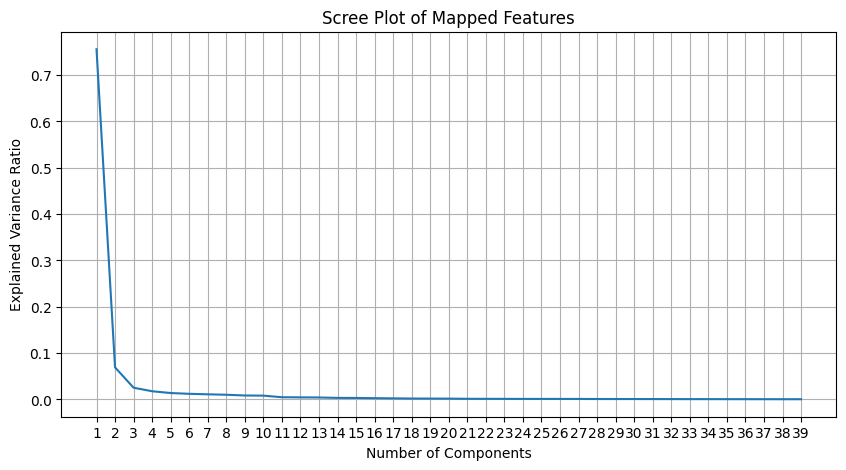

In [ ]:
# Create Scree Plot to determine how many features to include

num_components = np.arange(1, 40)
pca = PCA(n_components=40)  
# pca.fit(data_expanded_df_nolabel)

pda_data = pca.fit(data_expanded_df) 

plt.figure(figsize=(10, 5))  
explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(num_components, explained_variance_ratio[:39], linestyle='-')  
plt.title('Scree Plot of Mapped Features')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(num_components)
plt.grid(True)
plt.show() 

In [ ]:
# From Scree Plot above, we will use the top 30 features for our data
pca_mapped_data = PCA(n_components=10)
pca_transform_mapped = pca_mapped_data.fit_transform(data_expanded_df)

print(pca_transform_mapped.shape)
pca_transform_mapped_df = pd.DataFrame(pca_transform_mapped)


(710, 10)


In [ ]:
# add back labels to final dataset

# pca_data_add_extra = pd.concat([pca_transform_mapped_df, extra_features_copy], axis = 1)

final_dataset = pd.concat([pca_transform_mapped_df, target], axis=1)

# final_dataset = pd.concat([pca_transform_mapped_df, target], axis=1)
print(final_dataset.shape)
final_dataset

(710, 11)


,0,1,2,3,4,5,6,7,8,9,aveOralM
0,3.892738,14.050235,1.132569,5.106886,2.172603,-0.550589,6.839984,7.309693,3.203156,0.541304,36.59
1,30.989611,-8.005984,-7.320709,5.590809,5.916808,1.042125,3.757071,14.225878,5.595837,0.303590,37.19
2,-14.660726,-1.639887,1.390188,-0.269396,0.406078,0.187846,0.297310,-0.508705,0.594601,-1.224113,37.34
3,-12.764102,-3.096280,0.933387,-2.041989,0.309462,1.104717,2.000088,4.141508,-0.739456,-0.039363,37.09
4,-14.637136,-1.538339,1.324819,-0.102956,0.481945,0.128360,0.152103,-0.554990,0.553798,-1.040844,37.04
...,...,...,...,...,...,...,...,...,...,...,...
705,-14.660502,-1.920854,1.206744,-0.329349,0.342343,0.077429,0.093535,-0.461401,0.728986,-1.184239,36.89
706,-13.081257,-0.866891,2.161389,-0.949642,1.733233,1.282178,0.850406,-1.430928,-1.366408,-1.203159,37.14
707,35.223511,-21.574853,3.115573,2.865497,-1.331382,-0.938776,7.813176,3.242030,-3.364078,4.300271,37.79
708,84.777912,-20.392252,-2.268418,18.244543,5.065245,-4.635285,1.173928,-0.671895,5.592824,1.057386,38.14


### Baseline model on entire feature mapped plus pca'd data

In [ ]:
x_train_pp = final_dataset.iloc[:, :-1]  # Features
y_train_pp = final_dataset.iloc[:, -1]   # Labels

x_train_poly_pca, x_val_poly_pca, y_train_poly_pca, y_val_poly_pca = train_test_split(x_train_pp, y_train_pp, test_size=0.2, random_state=42)

print(x_train_poly_pca.shape)
print(x_val_poly_pca.shape)
print(y_train_poly_pca.shape)
print(y_val_poly_pca.shape)

(568, 10)
(142, 10)
(568,)
(142,)


In [ ]:
# Convert feature names to strings for x_train_poly_pca and x_val_poly_pca
# x_train_poly_pca.columns = x_train_poly_pca.columns.astype(str)
# x_val_poly_pca.columns = x_val_poly_pca.columns.astype(str)

# # Now train the Linear Regression model
# model_test_prediction_pp = LinReg(x_train_poly_pca, y_train_poly_pca, x_val_poly_pca, y_val_poly_pca) # train linear regression model

# mse_pp, r_mse_pp, mae_pp = compute_metrics(y_val_poly_pca, model_test_prediction_pp) # calculate metrics

# print("Mean Squared Error for all features: ", mse_pp)
# print("Root Mean Squared Error for all features: ", r_mse_pp)
# print("Mean Absolute Error for all features: ", mae_pp)

### Path 2: Feature Reduction Selection and PCA

#### Sequential feature selection

In [ ]:
# #Feature Reduction using Sequential Forward Feature Selection
# def seq_back_feat_select(model_reduce, n_features_to_select, direction):

#     # Create a SequentialFeatureSelector object for backward selection
#     sfs_backward = SequentialFeatureSelector(estimator=model_reduce, n_features_to_select=n_features_to_select, direction=direction)
#     sfs_backward.fit(x_train, y_train)

#     # Get the names of selected features
#     selected_features_backward = x_train.columns[sfs_backward.support_]
    
#     return selected_features_backward 

In [ ]:
# # perform sequential feature selection for various number of features and validate the metrics each epoch
# num_feats = x_train.shape[1]
# feature_select_mse = []

# for i in range(1, num_feats):
#     # print(f"Number of features: {i}")
#     selected_features_backward = seq_back_feat_select(LinearRegression(), i, 'forward')

#     #extract features from x_train and x_val
#     x_train_select_features = x_train[selected_features_backward].copy()
#     x_val_select_features = x_val[selected_features_backward].copy()

#     model_test_predict_select_features = LinReg(x_train_select_features, y_train, x_val_select_features, y_val)
#     mse_sf, r_mse_sf, mae_sf = compute_metrics(y_val, model_test_predict_select_features)

#     feature_select_mse.append(mse_sf)

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(feature_select_mse, marker='o', linestyle='-')
# plt.title('Sequential Feature Selection MSE')
# plt.xlabel('Number of Features')
# plt.ylabel('MSE')
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# # From plot we can see that we should take the top {TO FILL} features

In [ ]:
# get features from best feature reduction: 26 features
# selected_features_backward = seq_back_feat_select(LinearRegression(), 26, 'forward')

# #extract features from x_train and x_val
# x_train_select_features = x_train[selected_features_backward].copy()
# x_val_select_features = x_val[selected_features_backward].copy()

In [ ]:
# full_dataset_reduced = np.concatenate((x_train_select_features, x_val_select_features), axis=0)
# full_dataset_reduced = pd.DataFrame(full_dataset_reduced)
# print(type(full_dataset_reduced))
# print(full_dataset_reduced.shape)
# # print(x_val_select_features.shape)

#### PCA 

In [ ]:
# PCA on entire dataset with reduced features

# num_components = np.arange(1, 26)
# pca = PCA(n_components=26)  
# pca.fit(norm_full_dataset_reduced)

# plt.figure(figsize=(10, 5))  
# explained_variance_ratio = pca.explained_variance_ratio_
# # cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# plt.plot(num_components, explained_variance_ratio[:25], marker='o', linestyle='-')  
# plt.title('Scree Plot')
# plt.xlabel('Number of Components')
# plt.ylabel('Explained Variance Ratio')
# plt.xticks(num_components)
# plt.grid(True)
# plt.show() 

In [ ]:
# num_components = XXXXXXXXXXXXX
# pca_dataset_reduced = PCA(n_components=13)
# pca_transform = pca_dataset_reduced.fit_transform(norm_full_dataset_reduced)

In [ ]:
############## add back labels
# dataset should be reduced from both sequential and pca, and it should be standardised, plus labels added on

### Train Test Split -> convert this to cross validation function

In [ ]:
# split data into test and validation sets
# y_training_data_reshaped = y_training_data_norm.values.reshape(-1, 1)
# final_dataset_x = pca_transform

# # X_training_data = final_dataset.iloc[:, :-1]  # Features
# # y_training_data = final_dataset.iloc[:, -1]   # Labels

# x_train, x_val, y_train, y_val = train_test_split(final_dataset_x, y_training_data_reshaped, test_size=0.2, random_state=42)

# print(x_train.shape)
# print(x_val.shape)
# print(y_train.shape)
# print(y_val.shape)

#### Trivial Solution
Mean output value

In [ ]:
#x_train_poly_pca, x_val_poly_pca, y_train_poly_pca, y_val_poly_pca

# A system that always outputs the mean output value y_pred from the training set. 
# y_pred = y_train.mean()
# y_pred_triv = np.array([y_pred]*len(y_val))
# mse, r_mse, mae = compute_metrics(y_val, y_pred_triv)

y_pred = y_train_poly_pca.mean()
y_pred_triv = np.array([y_pred]*len(y_val_poly_pca))
mse, r_mse, mae = compute_metrics(y_val_poly_pca, y_pred_triv)



print("Label means: ", y_pred)
print("Mean Squared Error for all features: ", mse)
print("Root Mean Squared Error for all features: ", r_mse)
print("Mean Absolute Error for all features: ", mae)

Label means:  36.991496478873245
Mean Squared Error for all features:  0.2632768253446733
Root Mean Squared Error for all features:  0.5131050821660932
Mean Absolute Error for all features:  0.3266613767109709


#### K fold Cross Validation Function

In [ ]:
#K fold validation for NN, Ridge Regression, Random Forest

def k_fold(data, labels, num_folds, model, model_parameters):
    kf = KFold(n_splits = num_folds, shuffle = True)

    mse = []
    rmse = []
    mae = []

    #from k-fold, split data into training and validation
    for train_index, test_index in kf.split(data):
        x_train, x_val = data.iloc[train_index].values, data.iloc[test_index].values
        y_train, y_val = labels.iloc[train_index].values.ravel(), labels.iloc[test_index].values.ravel()

        model_predictions = model(x_train, y_train, x_val, y_val, model_parameters)

        model_mse, model_rmse, model_mae = compute_metrics(y_val, model_predictions)

        print(x_train.shape)
        print(x_val.shape)

        mse.append(model_mse)
        rmse.append(model_rmse)
        mae.append(model_mae)

    mean_mse = np.mean(mse)
    mean_rmse = np.mean(rmse)
    mean_mae = np.mean(mae)

    return mean_mse, mean_rmse, mean_mae

#### Baseline Models

##### Linear Regression (No Regularisation)

In [ ]:
#x_train_poly_pca, y_train_poly_pca, x_val_poly_pca, y_val_poly_pca

# model_test_prediction = LinReg(x_train, y_train, x_val, y_val) # train linear regression model

# mse_all, r_mse_all, mae_all = compute_metrics(y_val, model_test_prediction) # calculate metrics

# print("Mean Squared Error for all features: ", mse_all)
# print("Root Mean Squared Error for all features: ", r_mse_all)
# print("Mean Absolute Error for all features: ", mae_all)

model_test_prediction = LinReg(x_train_poly_pca, y_train_poly_pca, x_val_poly_pca, y_val_poly_pca) # train linear regression model

mse_all, r_mse_all, mae_all = compute_metrics(y_val_poly_pca, model_test_prediction) # calculate metrics

print("Mean Squared Error for all features: ", mse_all)
print("Root Mean Squared Error for all features: ", r_mse_all)
print("Mean Absolute Error for all features: ", mae_all)

Mean Squared Error for all features:  0.0950908930024028
Root Mean Squared Error for all features:  0.30836811281713744
Mean Absolute Error for all features:  0.2270320939934537


##### 1NN (Nearest Neighbour)

In [ ]:
#RH

def Nearest_Neighbors(train_data, train_label, val_data, val_label, k_val):
    knn = KNeighborsRegressor(n_neighbors = k_val)

    knn.fit(train_data, train_label)

    predictions = knn.predict(val_data)

    return predictions

# one_NN_pred = Nearest_Neighbors(x_train, y_train, x_val, y_val, 1)
# mse_oneNN, r_mse_oneNN, mae_oneNN = compute_metrics(y_val, one_NN_pred) # calculate metrics for 1 NN

# one_NN_pred = Nearest_Neighbors(x_train_poly_pca, y_train_poly_pca, x_val_poly_pca, y_val_poly_pca, 1)
# mse_oneNN, r_mse_oneNN, mae_oneNN = compute_metrics(y_val_poly_pca, one_NN_pred) # calculate metrics for 1 NN

# print("Mean Squared Error for all features: ", mse_oneNN)
# print("Root Mean Squared Error for all features: ", r_mse_oneNN)
# print("Mean Absolute Error for all features: ", mae_oneNN)

mse_oneNN, r_mse_oneNN, mae_oneNN = k_fold(x_train_pp, y_train_pp, 5, Nearest_Neighbors, 1)

print("Mean Squared Error for all features: ", mse_oneNN)
print("Root Mean Squared Error for all features: ", r_mse_oneNN)
print("Mean Absolute Error for all features: ", mae_oneNN)

(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
Mean Squared Error for all features:  0.16170070422535224
Root Mean Squared Error for all features:  0.40145944646725995
Mean Absolute Error for all features:  0.30190140845070423


#### In-Class Regression Models

##### Ridge Regression

In [ ]:
#RH

def ridge_regression(train_data, train_label, val_data, val_label, lambda_val):
    rr_model = Ridge(alpha=lambda_val)
    rr_model.fit(train_data, train_label)

    # Predicting on the test set
    rr_pred = rr_model.predict(val_data)

    return rr_pred

# lambda_values = [0.001, 0.005, 0.01, 0.1, 1, 5, 10, 100, 1000, 10000]
lambda_values = [1,2,3,4,5,6,7,8,9,10]

mse_rr_values = []
r_mse_rr_values = []
mae_rr_values = []

for i in lambda_values:
    mse_rr, r_mse_rr, mae_rr = k_fold(x_train_pp, y_train_pp, 5, ridge_regression, i)

    mse_rr_values.append(mse_rr)
    r_mse_rr_values.append(r_mse_rr)
    mae_rr_values.append(mae_rr)

    print("Mean Squared Error for lambda =", i, ":", mse_rr)
    print("Root Mean Squared Error for lambda =", i, ":", r_mse_rr)
    print("Mean Absolute Error for lambda =", i, ":", mae_rr)
    print("")


# for i in lambda_values:
#     # rr_predictions = ridge_regression(x_train, y_train, x_val, y_val, i)
#     # mse_rr, r_mse_rr, mae_rr = compute_metrics(y_val, rr_predictions)
#     rr_predictions = ridge_regression(x_train_poly_pca, y_train_poly_pca, x_val_poly_pca, y_val_poly_pca, i)
#     mse_rr, r_mse_rr, mae_rr = compute_metrics(y_val_poly_pca, rr_predictions)

#     mse_rr_values.append(mse_rr)
#     r_mse_rr_values.append(r_mse_rr)
#     mae_rr_values.append(mae_rr)

#     print("Mean Squared Error for lambda =", i, ":", mse_rr)
#     print("Root Mean Squared Error for lambda =", i, ":", r_mse_rr)
#     print("Mean Absolute Error for lambda =", i, ":", mae_rr)
#     print("")


(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
Mean Squared Error for lambda = 1 : 0.0915853592816421
Root Mean Squared Error for lambda = 1 : 0.3022618924507875
Mean Absolute Error for lambda = 1 : 0.22911626816880132

(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
Mean Squared Error for lambda = 2 : 0.08674886082874823
Root Mean Squared Error for lambda = 2 : 0.29369695053511513
Mean Absolute Error for lambda = 2 : 0.22477811421577337

(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
Mean Squared Error for lambda = 3 : 0.08888983347023893
Root Mean Squared Error for lambda = 3 : 0.2976826426742899
Mean Absolute Error for lambda = 3 : 0.2264147883745215

(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
Mean Squared Error for lambda = 4 : 0.08881543741739603
Root Mean Squared Error

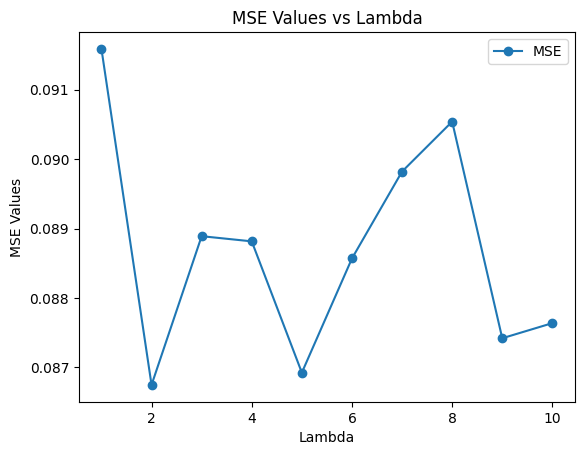

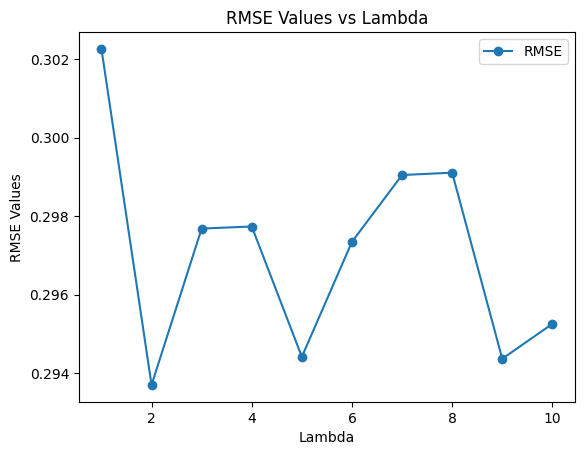

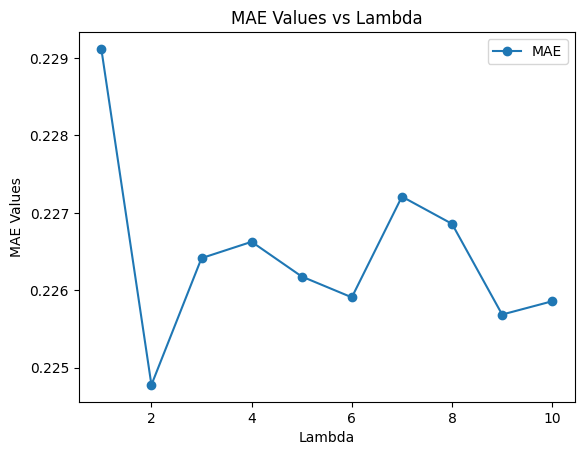

In [ ]:
# Plotting MSE for Ridge Regression
plt.plot(lambda_values, mse_rr_values, label='MSE', marker='o')
plt.xlabel('Lambda')
plt.ylabel('MSE Values')
plt.title('MSE Values vs Lambda')
plt.legend()
plt.show()

# Plotting RMSE for Ridge Regression
plt.plot(lambda_values, r_mse_rr_values, label='RMSE', marker='o')
plt.xlabel('Lambda')
plt.ylabel('RMSE Values')
plt.title('RMSE Values vs Lambda')
plt.legend()
plt.show()

# Plotting MAE for Ridge Regression
plt.plot(lambda_values, mae_rr_values, label='MAE', marker='o')
plt.xlabel('Lambda')
plt.ylabel('MAE Values')
plt.title('MAE Values vs Lambda')
plt.legend()
plt.show()

##### K-Nearest Neighbours Regression

In [ ]:
#HC

k_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mse_NN_values = []
r_mse_NN_values = []
mae_NN_values = []

for i in k_values:
    mse_NN, r_mse_NN, mae_NN = k_fold(x_train_pp, y_train_pp, 5, Nearest_Neighbors, i)

    mse_NN_values.append(mse_NN)
    r_mse_NN_values.append(r_mse_NN)
    mae_NN_values.append(mae_NN)

    print("Mean Squared Error for k = ", i, ": ", mse_NN)
    print("Root Mean Squared Error for k = ", i, ": ", r_mse_NN)
    print("Mean Absolute Error for k = ", i, ": ", mae_NN)
    print("")

# for i in k_values:
#     NN_predictions = Nearest_Neighbors(x_train, y_train, x_val, y_val, i)

#     mse_NN, r_mse_NN, mae_NN = compute_metrics(y_val, NN_predictions)

#     mse_NN_values.append(mse_NN)
#     r_mse_NN_values.append(r_mse_NN)
#     mae_NN_values.append(mae_NN)

#     print("Mean Squared Error for k = ", i, ": ", mse_NN)
#     print("Root Mean Squared Error for k = ", i, ": ", r_mse_NN)
#     print("Mean Absolute Error for k = ", i, ": ", mae_NN)
#     print("")

(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
Mean Squared Error for k =  1 :  0.16819718309859172
Root Mean Squared Error for k =  1 :  0.4088881277255729
Mean Absolute Error for k =  1 :  0.30309859154929597

(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
Mean Squared Error for k =  2 :  0.11879753521126765
Root Mean Squared Error for k =  2 :  0.3423164426007296
Mean Absolute Error for k =  2 :  0.26091549295774635

(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
Mean Squared Error for k =  3 :  0.10808959311424107
Root Mean Squared Error for k =  3 :  0.32823902234152097
Mean Absolute Error for k =  3 :  0.2492253521126761

(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
(568, 10)
(142, 10)
Mean Squared Error for k =  4 :  0.10639920774647885
Root Mean Squared Error for k =  4 :  0.324358429975

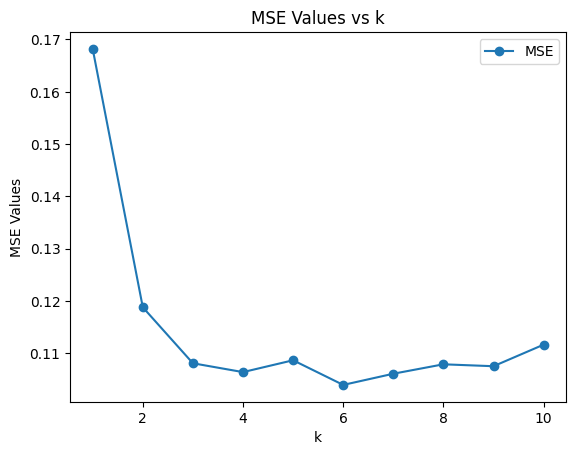

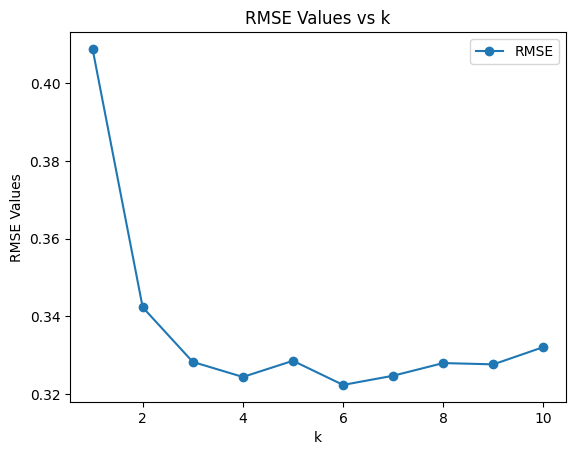

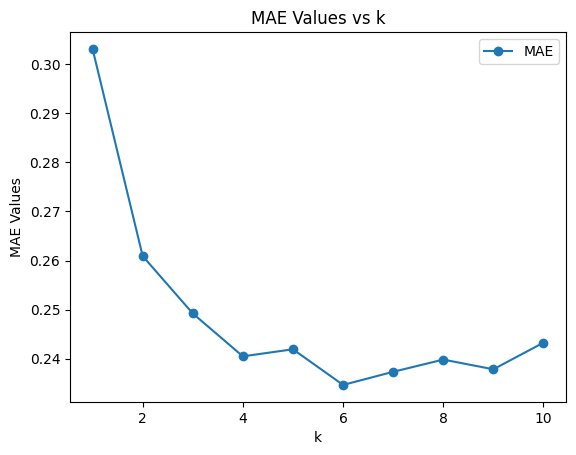

In [ ]:
# Plotting MSE for NN
plt.plot(k_values, mse_NN_values, label='MSE', marker='o')
plt.xlabel('k')
plt.ylabel('MSE Values')
plt.title('MSE Values vs k')
plt.legend()
plt.show()

# Plotting RMSE for NN
plt.plot(k_values, r_mse_NN_values, label='RMSE', marker='o')
plt.xlabel('k')
plt.ylabel('RMSE Values')
plt.title('RMSE Values vs k')
plt.legend()
plt.show()

# Plotting MAE for NN
plt.plot(k_values, mae_NN_values, label='MAE', marker='o')
plt.xlabel('k')
plt.ylabel('MAE Values')
plt.title('MAE Values vs k')
plt.legend()
plt.show()

##### Support Vector Regression (SVR)

In [ ]:
# perform feature reduction for svr only

In [ ]:
#RH

def svr(train_data, train_label, val_data, val_label, kernel_type, C_value, epsilon_value):
    svr_model = SVR(kernel = kernel_type, C = C_value, epsilon = epsilon_value)

    svr_model.fit(train_data, train_label)

    svr_pred = svr_model.predict(val_data)

    return svr_pred

In [ ]:
def k_fold_svr(data, labels, num_folds, kernel_type, c_value, epsilon):
    kf = KFold(n_splits = num_folds, shuffle = True)

    mse = []
    rmse = []
    mae = []

    #from k-fold, split data into training and validation
    for train_index, test_index in kf.split(data):
        x_train, x_val = data.iloc[train_index].values, data.iloc[test_index].values
        y_train, y_val = labels.iloc[train_index].values.ravel(), labels.iloc[test_index].values.ravel()

        # model_predictions = model(x_train, y_train, x_val, y_val, model_parameters)

        # model_mse, model_rmse, model_mae = compute_metrics(y_val, model_predictions)

        svr_predictions = svr(x_train, y_train.ravel(), x_val, y_val.ravel(), kernel_type, c_value, epsilon)

        mse_svr, r_mse_svr, mae_svr = compute_metrics(y_val, svr_predictions)

        mse.append(mse_svr)
        rmse.append(r_mse_svr)
        mae.append(mae_svr)

    mean_mse = np.mean(mse)
    mean_rmse = np.mean(rmse)
    mean_mae = np.mean(mae)

    return mean_mse, mean_rmse, mean_mae

In [ ]:
kernel_types = ['rbf', 'linear', 'poly', 'sigmoid']

C = 0.1
epsilon = 0.01

# C_values = [0.1, 1, 5, 10]
# epsilon_values = [0.01, 0.1, 0.5, 1]

mse_svr_values = []
r_mse_svr_values = []
mae_svr_values = []

for i in kernel_types:
    mse_svr, r_mse_svr, mae_svr = k_fold_svr(x_train_pp, y_train_pp, 10, i, C, epsilon)
    # svr_predictions = svr(x_train, y_train.ravel(), x_val, y_val.ravel(), i, C, epsilon)

    # mse_svr, r_mse_svr, mae_svr = compute_metrics(y_val, svr_predictions)

    print("Mean Squared Error for", i, "Kernel:", mse_svr)
    print("Root Mean Squared Error for", i, "Kernel:", r_mse_svr)
    print("Mean Absolute Error for", i, "Kernel:", mae_svr)
    print("")



# for i in kernel_types:
#     for j in C_values:
#         for k in epsilon_values:
#             svr_predictions = svr(x_train, y_train, x_val, y_val, i, j, k)

#             mse_svr, r_mse_svr, mae_svr = compute_metrics(y_val, svr_predictions)

#             mse_svr_values.append(mse_svr)
#             # r_mse_svr_values.append(r_mse_svr)
#             # mae_svr_values.append(mae_svr)

#             print("Mean Squared Error for Kernel Type: ", i, ", and Epsilon = ", k, ", and C = ", j, ": ", mse_svr)


Mean Squared Error for rbf Kernel: 0.16504756898773423
Root Mean Squared Error for rbf Kernel: 0.4010511447616506
Mean Absolute Error for rbf Kernel: 0.26956351954228497

Mean Squared Error for linear Kernel: 0.08837703572296413
Root Mean Squared Error for linear Kernel: 0.29520372177339804
Mean Absolute Error for linear Kernel: 0.22552680097692349

Mean Squared Error for poly Kernel: 1.2466368734902307
Root Mean Squared Error for poly Kernel: 0.8915482272514952
Mean Absolute Error for poly Kernel: 0.3533448934733533

Mean Squared Error for sigmoid Kernel: 2.3386239543300182
Root Mean Squared Error for sigmoid Kernel: 1.441398903811569
Mean Absolute Error for sigmoid Kernel: 0.6245579030190975



In [ ]:
#we see that linear Kernel has the lowest error 

# C_values = [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000]
# C_values = [0.1,1,2,3,4,5,6,7,8,9,10,12,14,16,18,20]
C_values = [0.1,1,10,20]

#epsilon = 0.01
mse_svr_C_values = []

for i in C_values:
    mse_svr_C, r_mse_svr_C, mae_svr_C = k_fold_svr(x_train_pp, y_train_pp, 5, 'linear', i, 0.01)

    mse_svr_C_values.append(mse_svr_C)

    print("Mean Squared Error for C =", i, ":", mse_svr_C)



# for i in C_values:
#     svr_predictions_C = svr(x_train, y_train.ravel(), x_val, y_val.ravel(), 'linear', i, epsilon)

#     mse_svr_C, r_mse_svr_C, mae_svr_C = compute_metrics(y_val, svr_predictions_C)

#     mse_svr_C_values.append(mse_svr_C)

#     print("Mean Squared Error for C =", i, ":", mse_svr_C)
#     # print("Root Mean Squared Error for C =", i, ":", r_mse_svr_C)
#     # print("Mean Absolute Error forC =", i, ":", mae_svr_C)
#     print("")

Mean Squared Error for C = 0.1 : 0.09323369525482048
Mean Squared Error for C = 1 : 0.09119680564886791
Mean Squared Error for C = 10 : 0.09194043120114673
Mean Squared Error for C = 20 : 0.09059389454541034


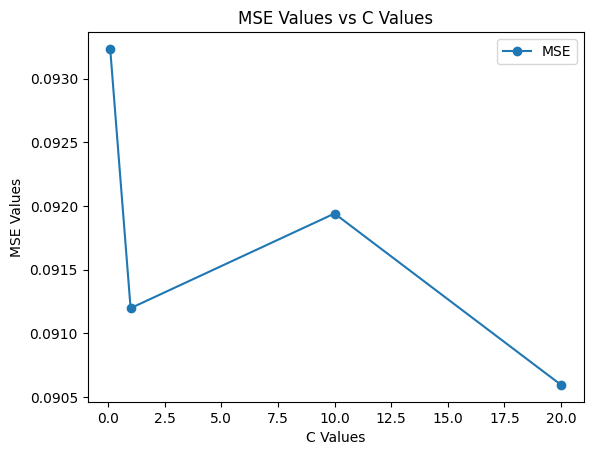

In [ ]:
# Plotting MSE for SVR a RBF Kernel: Epsilon = 0.01, C Changes
plt.plot(C_values, mse_svr_C_values, label='MSE', marker='o')
plt.xlabel('C Values')
plt.ylabel('MSE Values')
plt.title('MSE Values vs C Values')
plt.legend()
plt.show()

In [ ]:
  #Lower values of C gives the best MSE

epsilon_values = [0.001, 0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10]
C = 0.1
mse_svr_epsilon_values = []

for i in epsilon_values:
    mse_svr_E, r_mse_svr_E, mae_svr_E = k_fold_svr(x_train_pp, y_train_pp, 5, 'linear', 0.1, i)

    mse_svr_epsilon_values.append(mse_svr_E)

    print("Mean Squared Error for C =", i, ":", mse_svr_C)

# for i in epsilon_values:
#     svr_predictions_E = svr(x_train, y_train.ravel(), x_val, y_val.ravel(), 'rbf', C, i)

#     mse_svr_E, r_mse_svr_E, mae_svr_E = compute_metrics(y_val, svr_predictions_E)

#     mse_svr_epsilon_values.append(mse_svr_E)

#     print("Mean Squared Error for Epsilon =", i, ":", mse_svr_E)
#     # print("Root Mean Squared Error for C =", i, ":", r_mse_svr_C)
#     # print("Mean Absolute Error forC =", i, ":", mae_svr_C)
#     print("")

Mean Squared Error for C = 0.001 : 0.09059389454541034
Mean Squared Error for C = 0.01 : 0.09059389454541034
Mean Squared Error for C = 0.1 : 0.09059389454541034
Mean Squared Error for C = 0.2 : 0.09059389454541034
Mean Squared Error for C = 0.5 : 0.09059389454541034
Mean Squared Error for C = 1 : 0.09059389454541034
Mean Squared Error for C = 2 : 0.09059389454541034
Mean Squared Error for C = 5 : 0.09059389454541034
Mean Squared Error for C = 10 : 0.09059389454541034


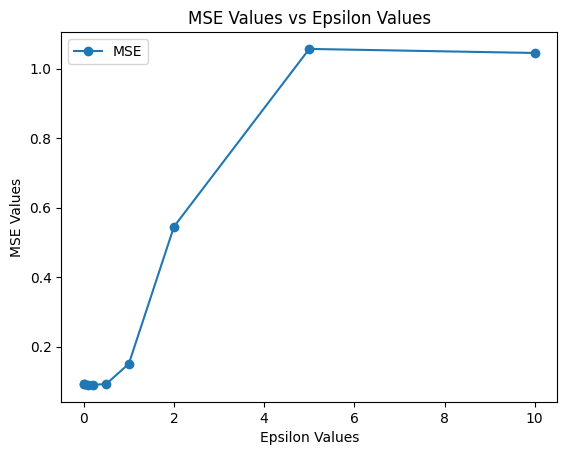

In [ ]:
# Plotting MSE for SVR a RBF Kernel: C = 0.1, Epsilon Changes
plt.plot(epsilon_values, mse_svr_epsilon_values, label='MSE', marker='o')
plt.xlabel('Epsilon Values')
plt.ylabel('MSE Values')
plt.title('MSE Values vs Epsilon Values')
plt.legend()
plt.show()

#### Out-of-Class Models

##### Random Forest

In [ ]:
def k_fold_rf(data, labels, num_folds, num_trees, num_max_depth, num_samples_split, num_max_features):
    kf = KFold(n_splits = num_folds, shuffle = True)

    mse = []
    rmse = []
    mae = []

    #from k-fold, split data into training and validation
    for train_index, test_index in kf.split(data):
        x_train, x_val = data.iloc[train_index].values, data.iloc[test_index].values
        y_train, y_val = labels.iloc[train_index].values.ravel(), labels.iloc[test_index].values.ravel()

        random_forest_model = RandomForestRegressor(n_estimators = num_trees, max_depth = num_max_depth, min_samples_split = num_samples_split, max_features = num_max_features, random_state = 42)
        random_forest_model.fit(x_train, y_train)
        predictions = random_forest_model.predict(x_val)

        model_mse, model_rmse, model_mae = compute_metrics(y_val, predictions)

        mse.append(model_mse)
        rmse.append(model_rmse)
        mae.append(model_mae)

    mean_mse = np.mean(mse)
    mean_rmse = np.mean(rmse)
    mean_mae = np.mean(mae)

    return mean_mse, mean_rmse, mean_mae

In [ ]:
#RH

def random_forest(train_data, train_label, val_data, val_label, num_trees, num_max_depth, num_samples_split, num_max_features):
    # random_forest_model = RandomForestRegressor(n_estimators = num_trees, random_state = 42)
    random_forest_model = RandomForestRegressor(n_estimators = num_trees, max_depth = num_max_depth, min_samples_split = num_samples_split, max_features = num_max_features, random_state = 42)
    random_forest_model.fit(train_data, train_label)
    predictions = random_forest_model.predict(val_data)

    return predictions



# def random_forest(train_data, train_label, val_data, val_label, num_trees):
#     # random_forest_model = RandomForestRegressor(n_estimators = num_trees, random_state = 42)
#     random_forest_model = RandomForestRegressor(n_estimators = num_trees,random_state = 42)
#     random_forest_model.fit(train_data, train_label)
#     predictions = random_forest_model.predict(val_data)

#     return predictions


In [ ]:
max_depth_values = [2, 5, 10, 20, 50]

for i in max_depth_values:
    mse_rf, r_mse_rf, mae_rf = k_fold_rf(x_train_pp, y_train_pp, 10, 50, i, 5, 'sqrt')

    print(f"Max Depth: {i} \n")

    print("Mean Squared Error: ", mse_rf)
    print("Root Mean Squared Error: ", r_mse_rf)
    print("Mean Absolute Error :", mae_rf)

Max Depth: 2 

Mean Squared Error:  0.15643671041323257
Root Mean Squared Error:  0.39262193913337307
Mean Absolute Error : 0.2781926184176585
Max Depth: 5 

Mean Squared Error:  0.12794948574786036
Root Mean Squared Error:  0.3548152236758964
Mean Absolute Error : 0.25217051002122043
Max Depth: 10 

Mean Squared Error:  0.11639676946464887
Root Mean Squared Error:  0.33890973959590653
Mean Absolute Error : 0.2412259702201353
Max Depth: 20 

Mean Squared Error:  0.11488069627827979
Root Mean Squared Error:  0.3364729859499767
Mean Absolute Error : 0.23919694233743302
Max Depth: 50 

Mean Squared Error:  0.11903822247654912
Root Mean Squared Error:  0.3418483985315829
Mean Absolute Error : 0.24074327774729226


In [ ]:
# depth_rf = [10, 50, 100, 250]

# for i in depth_rf:
#     rf_parameters = {'num_trees': 50, 'max_depth': i, 'min_samples_leaf': 1, 'max_features': 'auto'}

#     mse_rf, r_mse_rf, mae_rf = k_fold(x_train_pp, y_train_pp, 2, random_forest, rf_parameters)

#     print(f"Number of Random Forests: {i} \n")
#     print("Mean Squared Error: ", mse_rf)
#     print("Root Mean Squared Error: ", r_mse_rf)
#     print("Mean Absolute Error :", mae_rf)
#     print("")



# num_tree_values = [10, 50, 100, 250]

# for i in num_tree_values:
#     mse_rf, r_mse_rf, mae_rf = k_fold(x_train_pp, y_train_pp, 2, random_forest, i)

#     print(f"Number of Random Forests: {i} \n")
#     print("Mean Squared Error: ", mse_rf)
#     print("Root Mean Squared Error: ", r_mse_rf)
#     print("Mean Absolute Error :", mae_rf)
#     print("")




# for i in num_tree_values:
#     rf_predictions = random_forest(x_train, y_train.ravel(), x_val, y_val.ravel(), i)
#     # rf_predictions = random_forest(x_train_poly_pca, y_train_poly_pca, x_val_poly_pca, y_val_poly_pca, i)
    
#     mse_rf, r_mse_rf, mae_rf = compute_metrics(y_val, rf_predictions)

#     print(f"Number of Random Forests: {i} \n")
#     print("Mean Squared Error: ", mse_rf)
#     print("Root Mean Squared Error: ", r_mse_rf)
#     print("Mean Absolute Error :", mae_rf)
#     print("")

##### Gradient Boosting

In [ ]:
# GB

##### LSTM or Pretrained

In [ ]:
# deep nn

### Results 

In [ ]:
#here we compare all the metrics results from all the models, and then pick the model that has the best metrics

### Final Prediction on Test Set

In [ ]:
# train that model we select from above on the entire training set, and then finalise it on the test

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=498fdfc4-75bb-4c68-a720-cea81bc987b7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>